<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Colour_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!make -C sparse_gaussian_elimination a.so

make: Entering directory '/content/sparse_gaussian_elimination'
make: 'a.so' is up to date.
make: Leaving directory '/content/sparse_gaussian_elimination'


In [2]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, jacobi
from network import ScoreNet

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

Files already downloaded and verified


In [3]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20
H = 28
W = 28
epoch = 2000 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

218 0


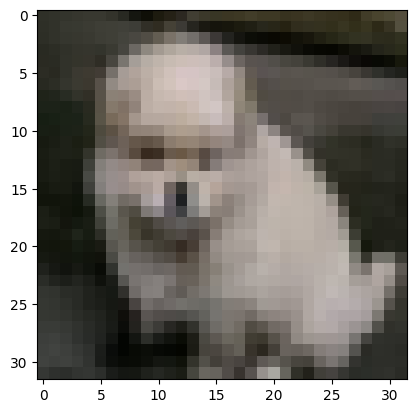

1.0 0.0


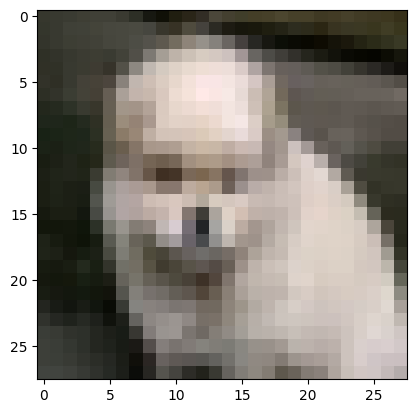

In [5]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(batch_size):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 28, 28)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[0].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [6]:
#@title Defining pde diffusion per thread
def diffuse(x, m, dm, channel, time_, g, scores):

  y_train = []
  for j in range(H):
    y_train.append(x[channel][j, :])
  y_train = np.concatenate(y_train)
  x_train = []
  for l in range(W):
    x_train.append(x[channel][:, l])
  x_train = np.concatenate(x_train)

  xy_train = np.vstack([x_train, y_train])
  kde_kernel = stats.gaussian_kde(xy_train)
  # xy_sample = kde_kernel.resample(seed=0)
  m[0, channel] = kde_kernel.logpdf(xy_train)
  dh = H*W / (256.*256.)
  dx = H / 256.
  dy = W / 256.

  A_block = []
  for i in range(1, N):
    f = np.zeros((H*W))
    df = np.zeros((H*W))
    A = construct_A(dh, dt, f, df, g(time_[i]), scores[i, channel].reshape((H*W)), H, W)#
    if i == 1:
      A_block = sp.linalg.block_diag(A)
    else:
      A_block = sp.linalg.block_diag(A_block, A)
      A_block[(i-1)*(H*W):i*(H*W), (i-2)*(H*W):(i-1)*(H*W)] = -np.eye((H*W))

  B_block = []
  for i in range(1, N):
    B = construct_B(m[i-1, channel], i, H, W)
    B_block.append(B)
  B_block = np.concatenate(B_block)
  m[1:, channel] = solve_pde(A_block, B_block, mode='sparse').reshape((-1, H*W))

  img_log_prob = m[:, channel].reshape((-1, H, W))
  dm[:, channel, 1:-1 , 1:-1] = (img_log_prob[:, 2:, 1:-1] - img_log_prob[:, :-2, 1:-1])/(2*dx) + (img_log_prob[:, 1:-1, 2:] - img_log_prob[:, 1:-1, :-2])/(2*dy)
  dm[:, channel, 1:-1 , 0] = (img_log_prob[:, 2:, 0] - img_log_prob[:, :-2, 0])/(2*dx) + (img_log_prob[:, 1:-1, 0])/(dy)
  dm[:, channel, 1:-1 , -1] = (img_log_prob[:, 2:, -1] - img_log_prob[:, :-2, -1])/(2*dx) + (img_log_prob[:, 1:-1, -1])/(dy)
  dm[:, channel, 0 , 1:-1] = (img_log_prob[:, 0, 2:] - img_log_prob[:, 0, :-2])/(2*dy) + (img_log_prob[:, 0, 1:-1])/(dx)
  dm[:, channel, -1 , 1:-1] = (img_log_prob[:, -1, 2:] - img_log_prob[:, -1, :-2])/(2*dy) + (img_log_prob[:, -1, 1:-1])/(dx)

In [7]:
#@title Precompute score labels by solving the PDE
threads = [None] * channels

m = np.zeros((N, channels, H*W), dtype=np.float32)
m_prev = np.ones((N, channels, H*W), dtype=np.float32)
scores = np.zeros((N, channels, H, W), dtype=np.float32) # initial scores guess
dm = np.zeros_like(scores, dtype=np.float32)
tol = 1e-3 #@param
max_iter = 1000 #@param
res = 1
e = 0
while res > tol:
  for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
    # we want to sample from random time steps to construct training samples
    time_ = np.linspace(eps, 1., N)

    # diffuse all three channels concurrently
    for ch in range(channels):
      diffuse(data, m, dm, ch, time_, diffusion_coeff_fn, scores)

    scores = dm.copy()

    if e == max_iter:
      print(f'No convergence')
      break

    res = np.linalg.norm(m - m_prev)#/np.linalg.norm(m_prev)
    print(f'residual at iteration {e}: {res}')

    m_prev = m.copy()
    e += 1

scores_label = scores.copy()

1it [00:46, 46.29s/it]


residual at iteration 0: 184.43231201171875


1it [00:27, 27.09s/it]


residual at iteration 1: 9.550494194030762


1it [00:27, 27.46s/it]


residual at iteration 2: 4.769001483917236


1it [00:27, 27.17s/it]


residual at iteration 3: 2.924910306930542


1it [00:29, 29.22s/it]


residual at iteration 4: 2.0558738708496094


1it [00:27, 27.25s/it]


residual at iteration 5: 1.6483455896377563


1it [00:27, 27.13s/it]


residual at iteration 6: 1.438449740409851


1it [00:27, 27.22s/it]


residual at iteration 7: 1.2999415397644043


1it [00:27, 27.14s/it]


residual at iteration 8: 1.186974287033081


1it [00:27, 27.82s/it]


residual at iteration 9: 1.081495761871338


1it [00:27, 27.03s/it]


residual at iteration 10: 0.9821061491966248


1it [00:27, 27.11s/it]


residual at iteration 11: 0.8852563500404358


1it [00:27, 27.18s/it]


residual at iteration 12: 0.7939031720161438


1it [00:39, 39.50s/it]


residual at iteration 13: 0.7067920565605164


1it [00:27, 27.41s/it]


residual at iteration 14: 0.6259231567382812


1it [00:27, 27.75s/it]


residual at iteration 15: 0.5507906675338745


1it [00:27, 27.10s/it]


residual at iteration 16: 0.48215043544769287


1it [00:27, 27.42s/it]


residual at iteration 17: 0.4197734594345093


1it [00:27, 27.24s/it]


residual at iteration 18: 0.3636155426502228


1it [00:27, 27.09s/it]


residual at iteration 19: 0.31348782777786255


1it [00:27, 27.59s/it]


residual at iteration 20: 0.26896148920059204


1it [00:27, 27.10s/it]


residual at iteration 21: 0.22979481518268585


1it [00:27, 27.44s/it]


residual at iteration 22: 0.19543519616127014


1it [00:27, 27.16s/it]


residual at iteration 23: 0.16558174788951874


1it [00:27, 27.22s/it]


residual at iteration 24: 0.13969193398952484


1it [00:27, 27.60s/it]


residual at iteration 25: 0.11743611097335815


1it [00:27, 27.31s/it]


residual at iteration 26: 0.09833814203739166


1it [00:27, 27.01s/it]


residual at iteration 27: 0.08207545429468155


1it [00:27, 27.15s/it]


residual at iteration 28: 0.0682544931769371


1it [00:27, 27.51s/it]


residual at iteration 29: 0.05658552423119545


1it [00:27, 27.61s/it]


residual at iteration 30: 0.04675561934709549


1it [00:27, 27.60s/it]


residual at iteration 31: 0.03852086514234543


1it [00:27, 27.09s/it]


residual at iteration 32: 0.03163939714431763


1it [00:27, 27.09s/it]


residual at iteration 33: 0.02591591514647007


1it [00:27, 27.74s/it]


residual at iteration 34: 0.0211679395288229


1it [00:39, 39.82s/it]


residual at iteration 35: 0.017245126888155937


1it [00:28, 28.10s/it]


residual at iteration 36: 0.014012660831212997


1it [00:27, 27.08s/it]


residual at iteration 37: 0.011358405463397503


1it [00:27, 27.22s/it]


residual at iteration 38: 0.009184617549180984


1it [00:27, 27.41s/it]


residual at iteration 39: 0.007409894373267889


1it [00:27, 27.17s/it]


residual at iteration 40: 0.005964639130979776


1it [00:27, 27.56s/it]


residual at iteration 41: 0.004790940321981907


1it [00:27, 27.14s/it]


residual at iteration 42: 0.003840082325041294


1it [00:27, 27.37s/it]


residual at iteration 43: 0.0030717619229108095


1it [00:27, 27.21s/it]


residual at iteration 44: 0.0024523581378161907


1it [00:27, 27.48s/it]


residual at iteration 45: 0.0019541243091225624


1it [00:27, 27.42s/it]


residual at iteration 46: 0.0015542292967438698


1it [00:27, 27.21s/it]


residual at iteration 47: 0.0012339898385107517


1it [00:29, 29.86s/it]

residual at iteration 48: 0.0009780623950064182


13.317394 -16.893488


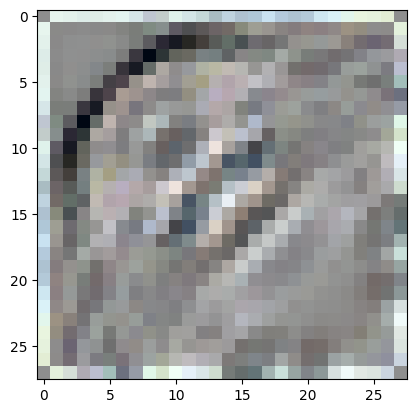

0.037601896 -0.0042793695


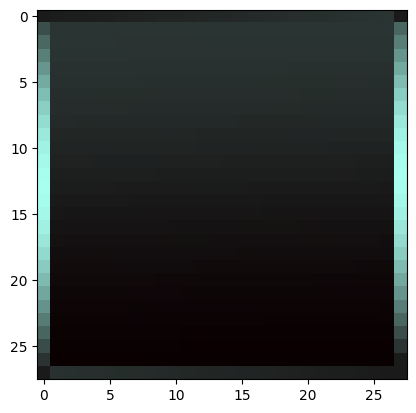

In [8]:
#@title Show the score labels
print(scores_label[0].max(), scores_label[0].min())
plt.imshow(((scores_label[0] - scores_label[0].min())/(scores_label[0].max() - scores_label[0].min())).transpose(1, 2, 0))
plt.show()
print(scores_label[-1].max(), scores_label[-1].min())
plt.imshow(((scores_label[-1] - scores_label[-1].min())/(scores_label[-1].max() - scores_label[-1].min())).transpose(1, 2, 0))
plt.show()

In [21]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps, 1., N)).astype(np.float32))
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * label[i-1] * diff_std2[i-1] * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [22]:
#@title Function for training on a thread
def diffuse_train(init_x, channel, epoch, diffusion_coeff, marginal_prob_std, label):
  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  optimizer = Adam(model_score.parameters(), lr=lr)
  model_score.train();

  scores_label = torch.tensor(label)[:, channel][:, None]

  for e in range(epoch):
    loss = loss_fn(model_score, init_x[:, channel][:, None], scores_label, diffusion_coeff, marginal_prob_std)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'\nloss at channel {channel}: {loss}')
  file = f'model_cifar_thread_{channel}.pth'
  torch.save(model_score.state_dict(), file)
  print(f"model for thread {channel} has been saved\n")

In [23]:
#@title Train each channel on a thread
if os.path.exists(f'model_cifar_thread_0.pth'):
  print(f'removing saved weights for thread 0\n')
  os.remove(f'model_cifar_thread_0.pth')
if os.path.exists(f'model_cifar_thread_1.pth'):
  print(f'removing saved weights for thread 1\n')
  os.remove(f'model_cifar_thread_1.pth')
if os.path.exists(f'model_cifar_thread_2.pth'):
  print(f'removing saved weights for thread 2\n')
  os.remove(f'model_cifar_thread_2.pth')

processes = [None] * channels
init_x = torch.zeros((N, channels, H, W))

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  for ch in range(channels):
    init_x[:, ch] = data[ch]

  # train all three channels concurrently
  for ch in range(channels):
    processes[ch] = multiprocessing.Process(target=diffuse_train, args=[init_x, ch, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label])
    processes[ch].start()

  for process in processes:
    process.join()

removing saved weights for thread 0

removing saved weights for thread 1

removing saved weights for thread 2



0it [00:00, ?it/s]


loss at channel 2: 137.16969299316406
model for thread 2 has been saved


loss at channel 1: 126.04197692871094
model for thread 1 has been saved


loss at channel 0: 143.14842224121094
model for thread 0 has been saved



1it [08:13, 493.65s/it]


In [24]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"\nNumber of function evaluations: {res.nfev}")
  x = [res.y[:, 0].reshape(shape)]
  T = len(res.t)
  for i in range(1, N-1):
    x.append(res.y[:, i].reshape(shape))
  x.append(res.y[:, -1].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [25]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, channel, samples, diffusion_coeff, marginal_prob_std):

  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  file = f'model_cifar_thread_{channel}.pth'
  ckpt = torch.load(file)
  model_score.load_state_dict(ckpt)
  model_score.eval();

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size)

  samples.append(output)

In [ ]:
#@title Sample each channel on a thread
threads = [None] * channels
samples = []

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  # diffuse all three channels concurrently
  for ch in range(channels):
    threads[ch] = threading.Thread(target=diffuse_sample, args=[data, ch, samples, diffusion_coeff_fn, marginal_prob_std_fn])
    threads[ch].start()

  for thread in threads:
    thread.join()

  samples = np.concatenate(samples, axis = 1)
  for i in range(samples.shape[0]):
    print(f'{samples[i].mean(), samples[i].std()}')
    plt.imshow(((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0))
    plt.show()

0it [00:00, ?it/s]